In [4]:
# Standard Imports
from __future__ import print_function
import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
from importlib import reload
from bs4 import BeautifulSoup
import requests
import scipy.stats as scs
import time
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import keras.backend as K
from tensorflow.keras.constraints import min_max_norm, non_neg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load MongoDB
from pymongo import MongoClient
client = MongoClient()
# Access/Initiate Database
db = client['producer_db']
# Access/Initiate Table
mfcc_tab = db['mfcc']
tab = db['songs']
collection = db.tab
mfcc_collection = db.mfcc_tab

# Authorize Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# # Audio Processing
# import librosa
# import librosa.display
# from IPython.display import Audio
# from scipy.io import wavfile
# from pydub import AudioSegment
# from src.audio_processing import load_mp3_from_url

In [45]:
a = collection.find_one()
a['track_info']

{'album': {'album_type': 'compilation',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
    'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
    'id': '3WrFJ7ztbogyGnTHbHJFl2',
    'name': 'The Beatles',
    'type': 'artist',
    'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
  'available_markets': ['AD',
   'AE',
   'AR',
   'AT',
   'AU',
   'BE',
   'BG',
   'BH',
   'BO',
   'BR',
   'CA',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'DZ',
   'EC',
   'EE',
   'EG',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HU',
   'ID',
   'IE',
   'IL',
   'IN',
   'IS',
   'IT',
   'JO',
   'JP',
   'KW',
   'LB',
   'LI',
   'LT',
   'LU',
   'LV',
   'MA',
   'MC',
   'MT',
   'MX',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'OM',
   'PA',
   'PE',
   'PH',
   'PL',
   'PS',
   'PT',
   'PY',
   'QA',
   'RO',
   'SA',
   'SE',
   'SG',
   

In [49]:
genres = sp.artist(a['track_info']['artists'][0]['id'])['genres']
a['producer'], a['spotify_id']

('George Martin', '2HvTGx5fzFGpHSyRNvXd9T')

In [6]:
collection.find_one()['artist']

'the Beatles'

In [8]:
artist_genres = {}
for i, song in enumerate(collection.find()):
    artist = song['artist']
    if song['track_info']['preview_url'] != None:
        if artist in artist_genres.keys():
            genres = artist_genres[artist]
        else:
            genres = sp.artist(song['track_info']['artists'][0]['id'])['genres']
            artist_genres[artist] = genres
        myquery = {'producer':song['producer'],
                   'spotify_id':song['spotify_id']
                  }

        newvalues = {'$set': {'genres':genres}
                    }

        mfcc_collection.update_one(myquery, newvalues, upsert = False)
        
    if i%100 == 0:
        print (i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300


In [9]:
a_new = mfcc_collection.find_one()
a_new.keys()

dict_keys(['_id', 'producer', 'spotify_id', 'MFCC', 'album', 'artist', 'preview_url', 'songs_mongs_id', 'track', 'genres'])

In [11]:
a_new['track'], a_new['artist'], a_new['genres']

('Act Naturally', 'Buck Owens and the Buckaroos', ['traditional country'])

# Let's get some numbers on those genres and classify!

In [36]:
genre_list = []
genre_df = []
for song in mfcc_collection.find():
    try:
        genre_list += song['genres']
        genre_df.append( (song['artist'],song['track'],song['genres']) )
    except:
        pass
genre_list = np.array(genre_list).flatten()
genre_df = pd.DataFrame(genre_df, columns = ['artist','track','genres'])

In [37]:
genre_df.head()

artist                   track  \
0  Buck Owens and the Buckaroos           Act Naturally   
1                   Cilla Black                   Alfie   
2                       America          Amber Cascades   
3                Dionne Warwick  Anyone Who Had a Heart   
4                 The Shirelles           Baby It's You   

                                              genres  
0                              [traditional country]  
1  [adult standards, brill building pop, bubblegu...  
2  [album rock, art rock, classic rock, country r...  
3  [adult standards, brill building pop, christma...  
4  [adult standards, brill building pop, bubblegu...

In [69]:
def assign_genre(genre_list):
    """
    Take a list of genres, return a basic genre
    """
    genre_sentence = ''
    for genre in genre_list:
        genre_sentence += ' ' + genre
    if 'country' in genre_sentence.lower():
        return 'country'
    if 'hip hop' in genre_sentence.lower():
        return 'hip hop'
    if 'rap' in genre_sentence.lower():
        return 'hip hop'
    if 'soul' in genre_sentence.lower():
        return 'soul'
    if 'pop' in genre_sentence.lower():
        return 'pop'
    if 'rock' in genre_sentence.lower():
        return 'rock'
    else:
        return None

In [70]:
genre_df['basic_genre'] = genre_df['genres'].apply(assign_genre)

In [67]:
genre_df.sample(20)

artist                                track  \
278             Audioslave                  Show Me How to Live   
206               Slipknot                      Before I Forget   
577                 Plan B                      Welcome to Hell   
575                 Plan B                        Stay Too Long   
596        The Futureheads                            Le Garage   
829                Shyheim                     Party's Goin' On   
517                  Adele                            River Lea   
897       Ghostface Killah                             Theodore   
733                 Monica  Don't Gotta Go Home (featuring DMX)   
85             the Beatles             I Want to Hold Your Hand   
540        Lianne La Havas                         Green & Gold   
499          Kylie Minogue                      My Secret Heart   
615  Pete Rock & CL Smooth            Mecca & the Soul Brothers   
288             Ed Sheeran                         Tenerife Sea   
818                Shyheim                          Pass It Off   
624              CL Smooth              I Get A Kick Out Of You   
865    Method Man & Redman                        Break the Ice   
726                 Brandy                              Finally   
943               The Cars           You Can't Hold On Too Long   
764            Chris Brown                            Tieflicht   

                                                genres basic_genre  
278  [alternative metal, alternative rock, hard roc...        rock  
206  [alternative metal, nu metal, post-grunge, rap...     hip hop  
577                                 [grime, uk garage]        None  
575                                 [grime, uk garage]        None  
596  [british indie rock, dance-punk, garage rock, ...        rock  
829                        [hardcore hip hop, hip hop]     hip hop  
517                        [british soul, pop, uk pop]        soul  
897  [alternative hip hop, east coast hip hop, gang...     hip hop  
733  [dance pop, deep pop r&b, hip pop, neo soul, n...        soul  
85   [british invasion, merseybeat, psychedelic roc...        rock  
540     [british soul, indie r&b, neo soul, r&b, soul]        soul  
499  [australian dance, australian pop, dance pop, ...         pop  
615  [alternative hip hop, east coast hip hop, gang...     hip hop  
288                                      [pop, uk pop]         pop  
818                        [hardcore hip hop, hip hop]     hip hop  
624    [adult standards, mellow gold, rock, soft rock]        rock  
865      [dance pop, pop, pop rap, post-teen pop, r&b]     hip hop  
726  [dance pop, hip hop, hip pop, neo soul, new ja...     hip hop  
943  [album rock, art rock, classic rock, dance roc...         pop  
764                                             [bboy]        None

In [68]:
genre_df['basic_genre'].value_counts()

hip hop    326
pop        264
rock       197
soul        52
country     24
Name: basic_genre, dtype: int64

This class balance looks about right. Let's add it to the mongo:

In [71]:
for song in mfcc_collection.find():
    basic_genre = assign_genre(song['genres'])
    
    myquery = {'producer':song['producer'],
               'spotify_id':song['spotify_id']
              }

    newvalues = {'$set': {'basic_genre':basic_genre}
                }

    mfcc_collection.update_one(myquery, newvalues, upsert = False)

In [86]:
X = []
y = []

for song in mfcc_collection.find():
    if np.array(song['MFCC']).shape[1] >= 1292:
        X.append(np.array(song['MFCC'])[:,:1292].flatten())
        y.append(song['basic_genre'])


#NEED TO STACK LIST OF MFCCS 
X = np.vstack(X)
y = np.array(y)

y_one_hot = pd.get_dummies(y).values
y_columns = np.array(pd.get_dummies(y).columns)

X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = 0.3, random_state = 440)

# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [176]:
def plot_mnist_embedding(ax, X, y, title=None, alpha = 1):
    """Plot an embedding of the mnist dataset onto a plane.
    
    Parameters
    ----------
    ax: matplotlib.axis object
      The axis to make the scree plot on.
      
    X: numpy.array, shape (n, 2)
      A two dimensional array containing the coordinates of the embedding.
      
    y: numpy.array
      The labels of the datapoints.  Should be digits.
      
    title: str
      A title for the plot.
    """
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    ax.axis('off')
    ax.patch.set_visible(False)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], 
                 str(y[i]), 
                 color=plt.cm.tab10((y[i]) / 10.), 
                 fontdict={'weight': 'bold', 'size': 12},
                 alpha = alpha)

    ax.set_xticks([]), 
    ax.set_yticks([])
    ax.set_ylim([-0.1,1.1])
    ax.set_xlim([-0.1,1.1])

    if title is not None:
        ax.set_title(title, fontsize=16)

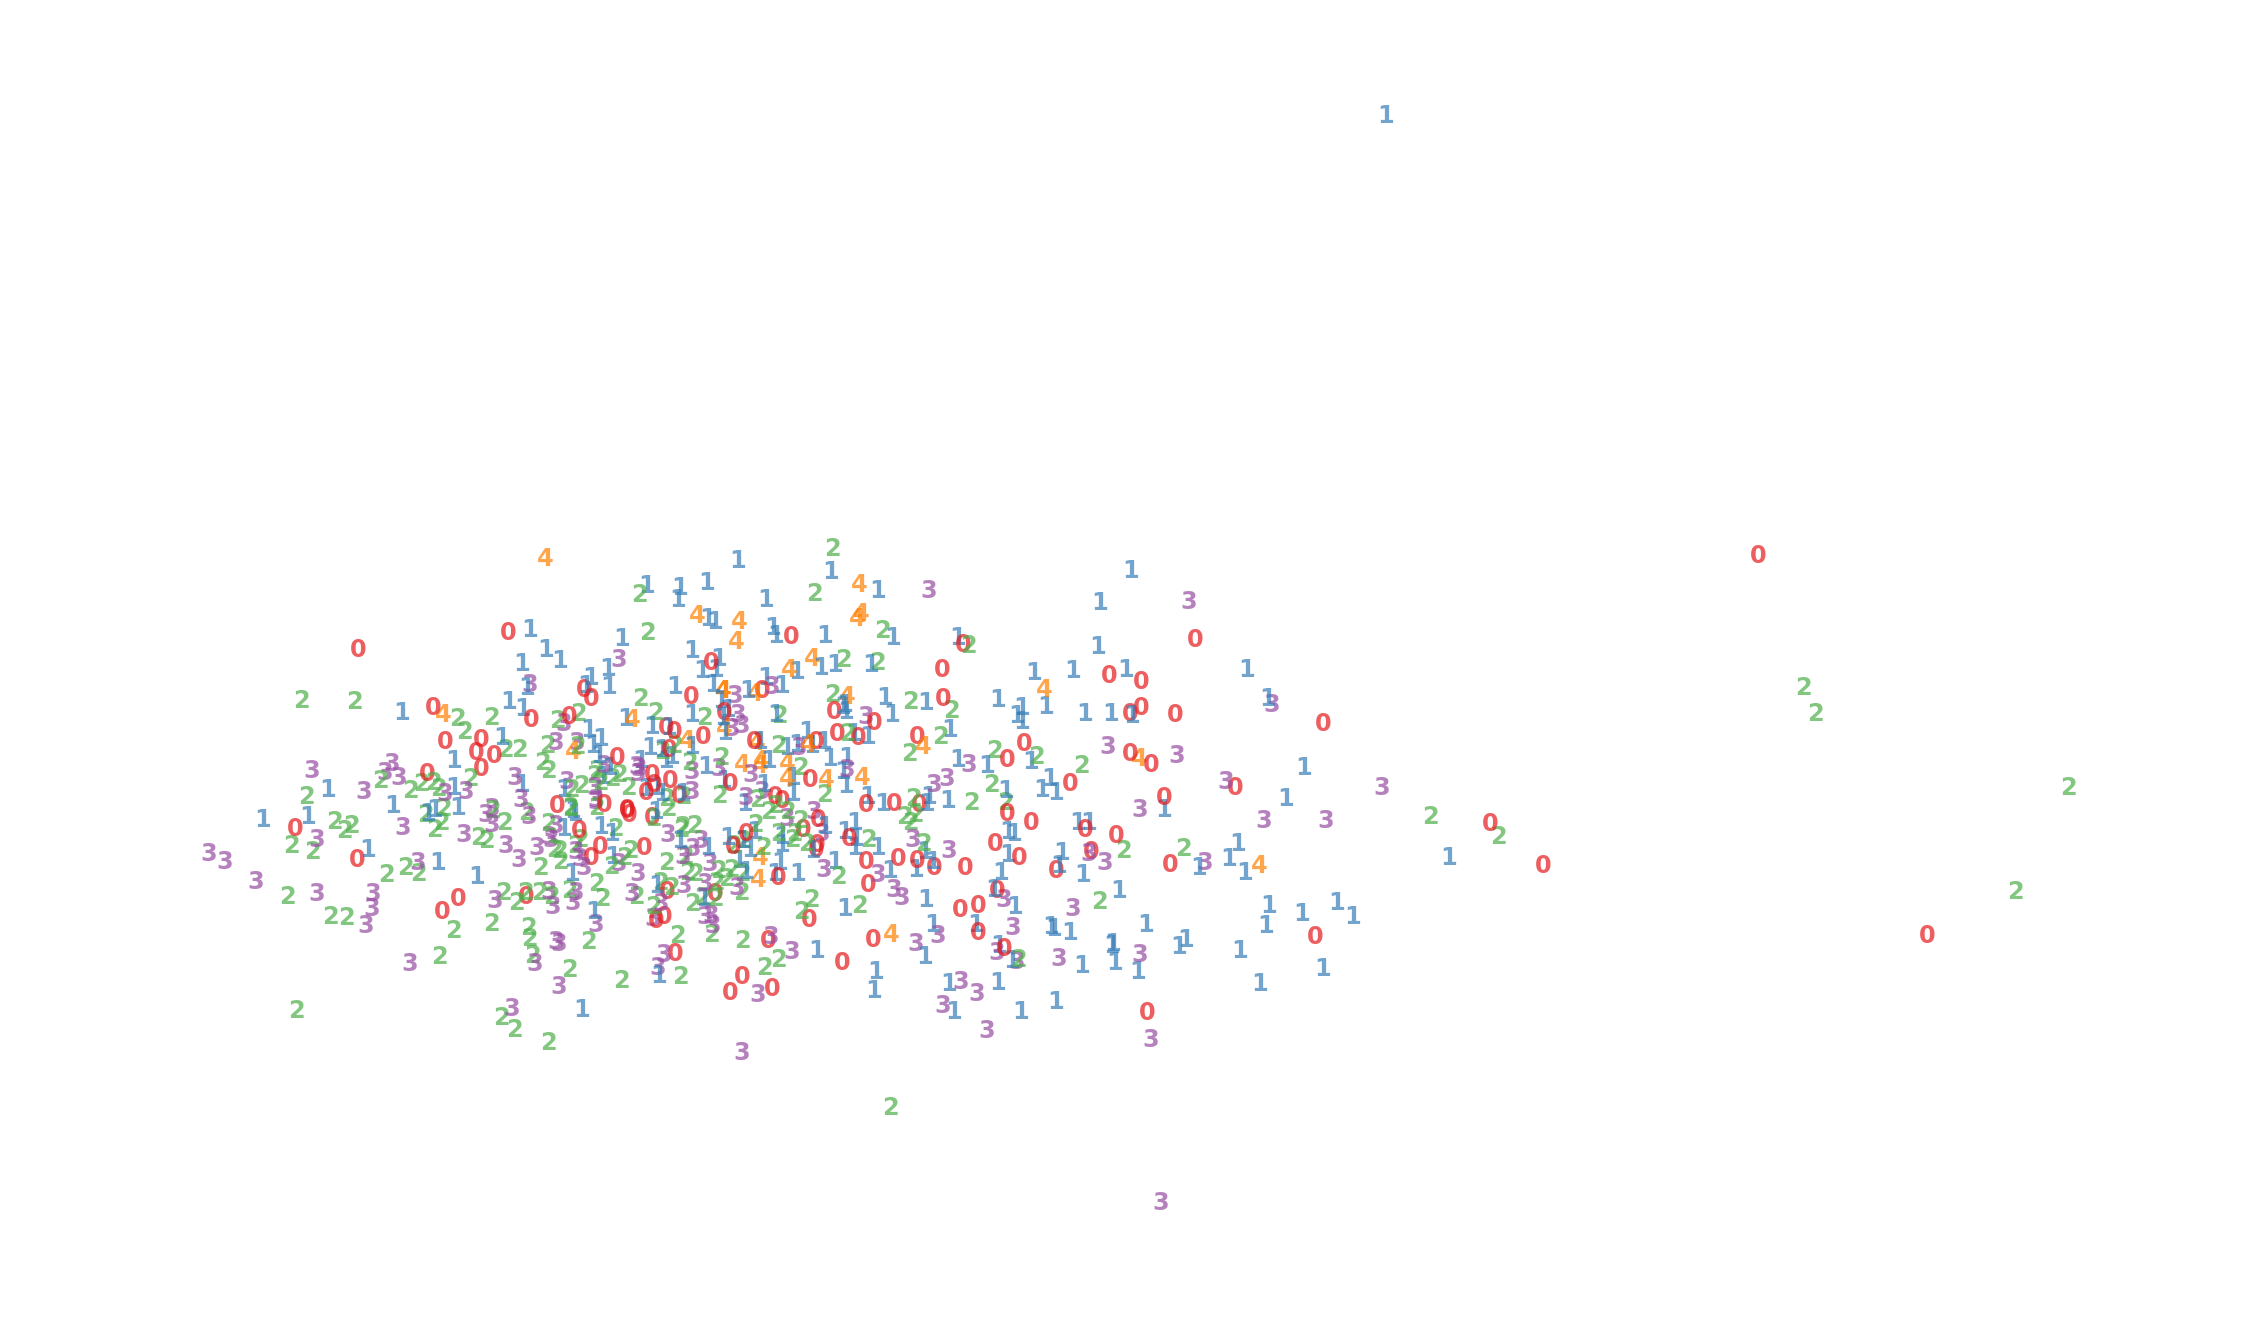

In [89]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scale)


fig, ax = plt.subplots(figsize=(20, 12))
plot_mnist_embedding(ax, X_pca[:,1:], np.argmax(y_train, axis = 1), alpha = 0.7)

/Users/Maxwell/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


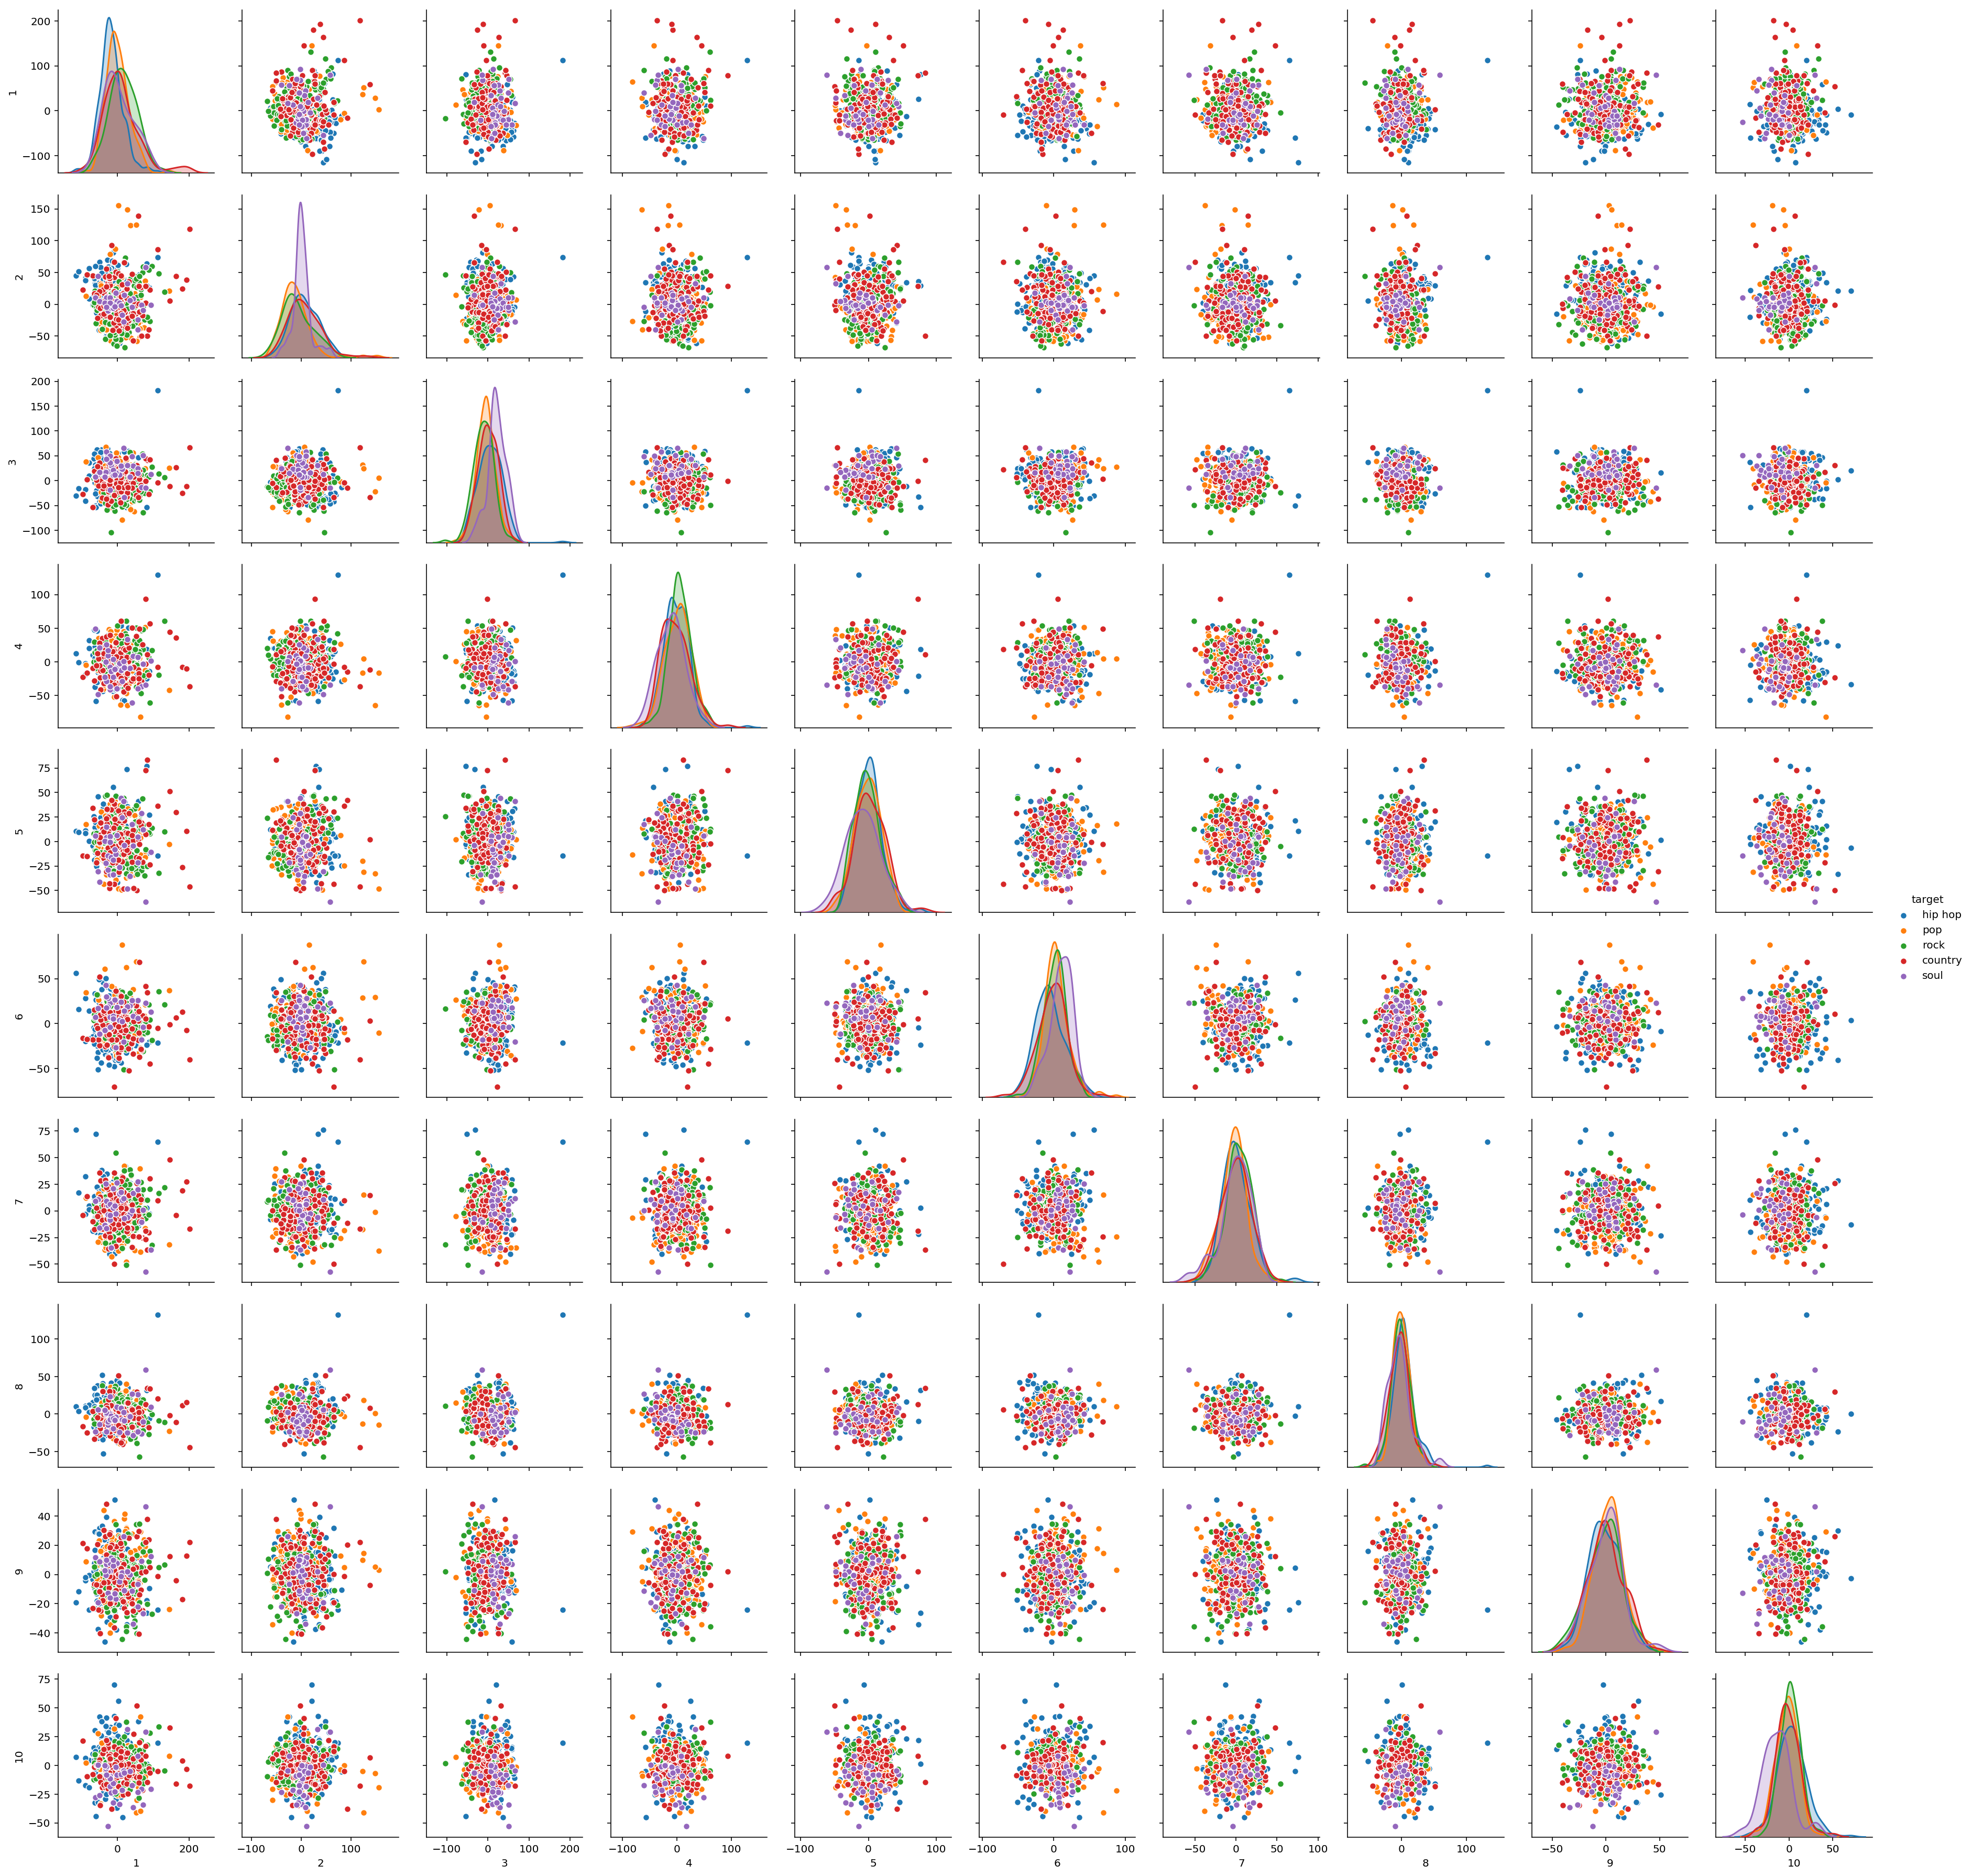

In [91]:
import seaborn as sns

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_train_scale)

X_pca_df = pd.DataFrame(np.concatenate((X_pca, y_columns[np.argmax(y_train, axis = 1)].reshape(-1,1)), axis = 1), columns = [1,2,3,4,5,6,7,8,9,10,'target'])
X_pca_df.head()

# pairwise plot
sns.pairplot(X_pca_df, hue = 'target')

In [92]:
model = models.Sequential()

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(12, 80, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# # model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(12, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

In [93]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.fit(X_train_scale, y_train, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20


^^^ Failed again. Thanks a lot, TensorFlow...

# Make a confusion matrix for KNN genre classification

In [7]:
# Make a Pandas DF
song_data = []
for song in mfcc_collection.find():
    new_song_data = (song['MFCC'],song['track'],song['artist'],song['producer'],song['basic_genre'])
    song_data.append(new_song_data)
    
song_df = pd.DataFrame(song_data, columns = ['MFCC','track','artist','producer','genre'])

In [8]:
song_df.head()

MFCC                   track  \
0  [[-36.601721668718625, -30.620147853873853, -4...           Act Naturally   
1  [[-81.25546252688608, -86.46493879315116, -94....                   Alfie   
2  [[-46.132845876649704, -56.27867828524279, -82...          Amber Cascades   
3  [[-332.453400860453, -308.416188638128, -280.7...  Anyone Who Had a Heart   
4  [[-143.51229171159966, -149.18152458636806, -1...           Baby It's You   

                         artist       producer    genre  
0  Buck Owens and the Buckaroos  George Martin  country  
1                   Cilla Black  George Martin      pop  
2                       America  George Martin  country  
3                Dionne Warwick  George Martin     soul  
4                 The Shirelles  George Martin     soul

Text(0, 0.5, 'Counts')

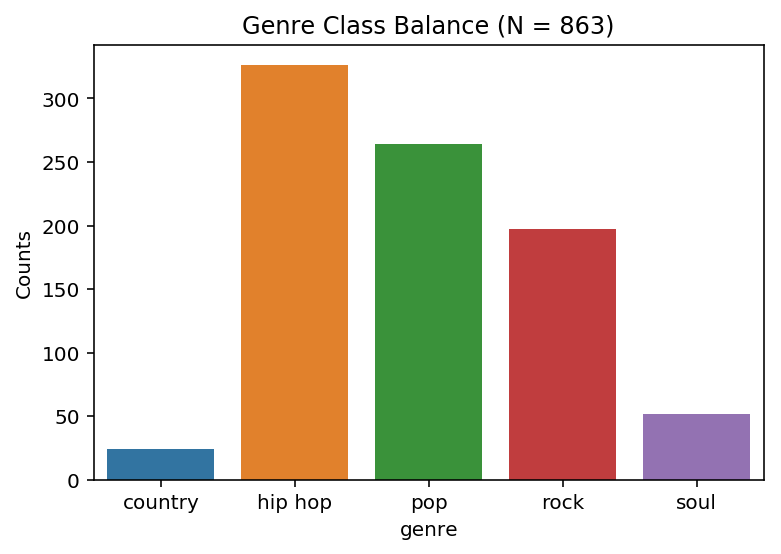

In [16]:
genre_count = song_df.groupby('genre').count()['producer']
sns.barplot(x = genre_count.index, y = genre_count)
plt.title('Genre Class Balance (N = {})'.format(genre_count.sum()))
plt.ylabel('Counts')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

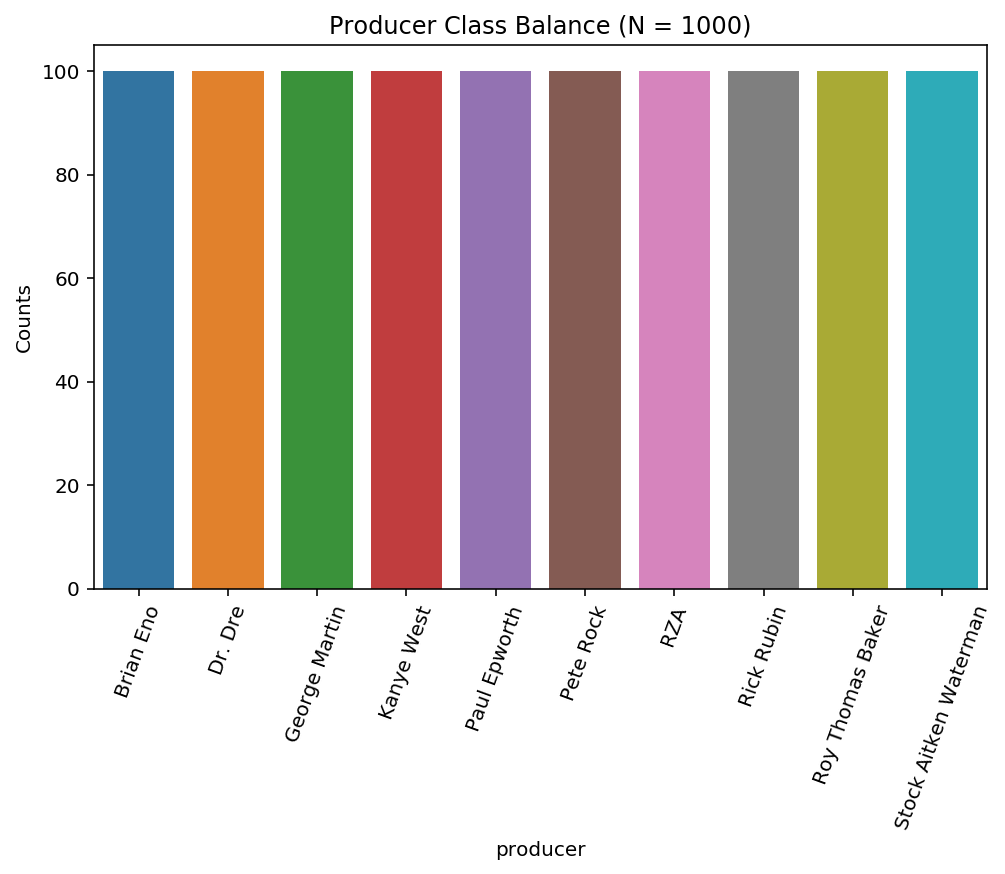

In [22]:
producer_count = song_df.groupby('producer').count()['MFCC']
plt.figure(figsize=(8,5))
sns.barplot(x = producer_count.index, y = producer_count)
plt.title('Producer Class Balance (N = {})'.format(producer_count.sum()))
plt.ylabel('Counts')
plt.xticks(rotation = 70)

In [129]:
X = []
y = []

for song in mfcc_collection.find():
    if np.array(song['MFCC']).shape[1] >= 1292:
        X.append(np.array(song['MFCC'])[:,:1292].flatten())
        y.append(song['basic_genre'])


#NEED TO STACK LIST OF MFCCS 
X = np.vstack(X)
y = np.array(y)

y_one_hot = pd.get_dummies(y).values
y_columns = np.array(pd.get_dummies(y).columns)

X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = 0.3, random_state = 440)

# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA(n_components=12)

X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [142]:
# Make a knn model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train_pca, y_train)

y_hat = knn.predict(X_test_pca)

# acc = knn.score(X_test, y_test)

# print('Genre Accuracy = {:.2f}'.format(acc))

In [143]:
from sklearn.metrics import confusion_matrix

In [144]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (9,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [145]:
y_test_labels = np.argmax(np.stack(knn.predict_proba(X_test_pca))[:,:,1].T, axis = 1)
y_hat_labels = np.argmax(y_hat, axis = 1)

In [146]:
acc = (y_test_labels == y_hat_labels).sum()/y_test_labels.size

print("Genre Accuracy = {}".format(acc))

Genre Accuracy = 0.6254180602006689


Confusion matrix, without normalization
[[13  0  0  0  0]
 [57 60  0  0  0]
 [39  0 76  0  0]
 [15  0  0 37  0]
 [ 1  0  0  0  1]]


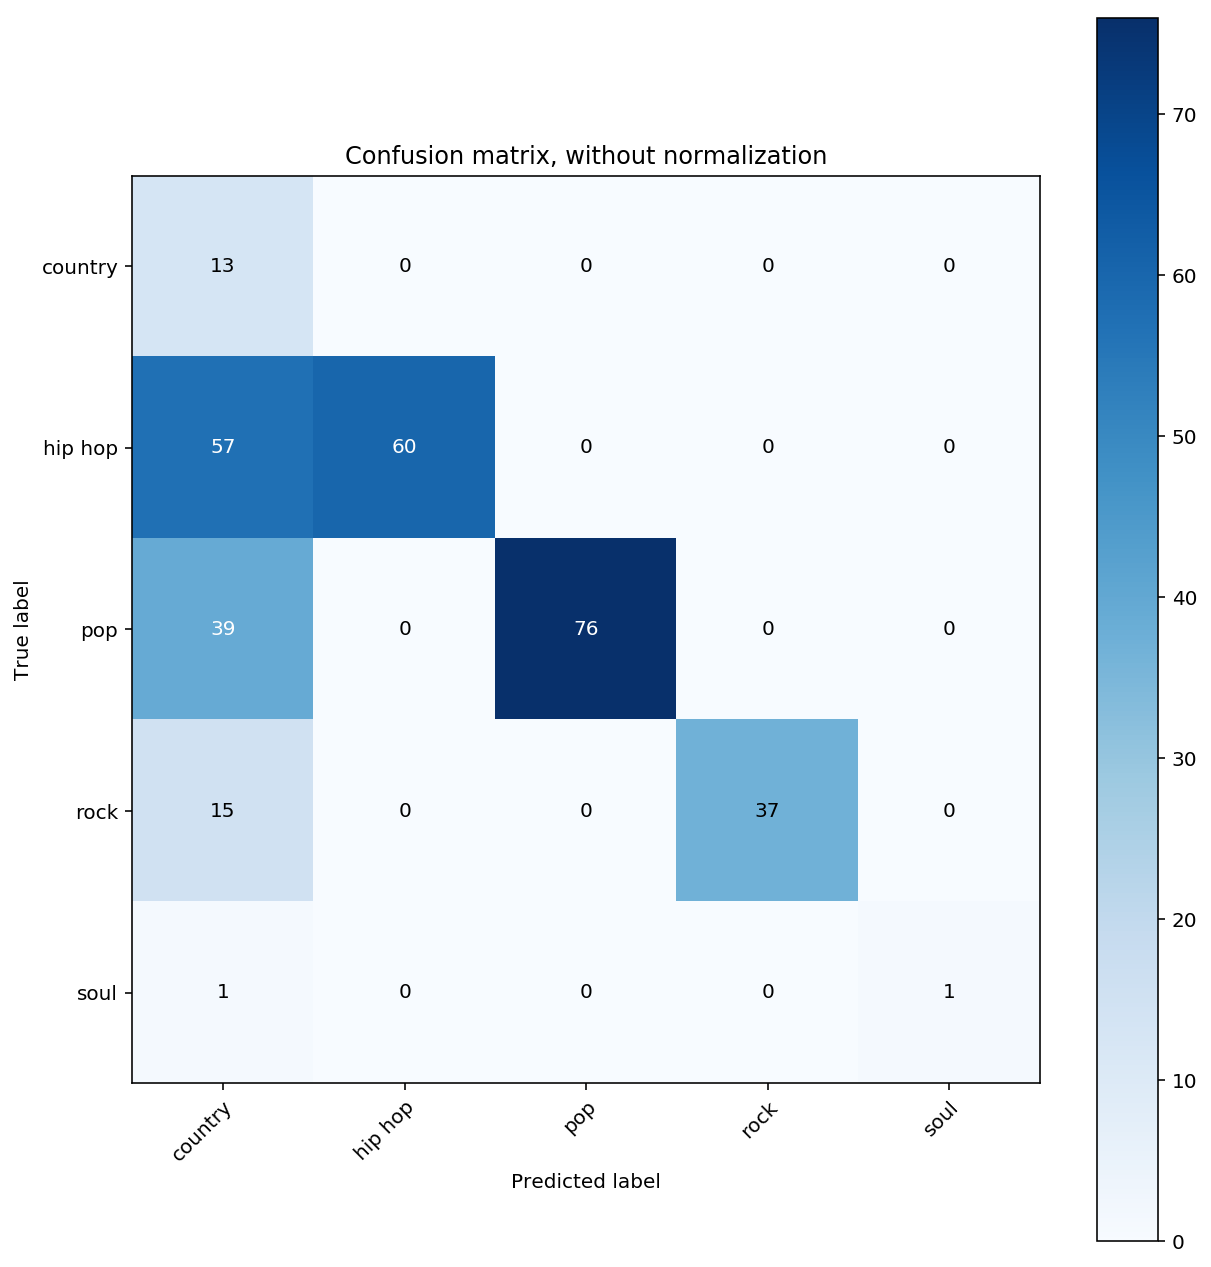

In [147]:
from sklearn.utils.multiclass import unique_labels

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_labels, y_hat_labels, classes=y_columns,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_had, classes=y_columns, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

**I think the labels are wrong!!!**

# And KNN For Producer Classification

In [50]:
X = []
y = []

for song in mfcc_collection.find():
    if np.array(song['MFCC']).shape[1] >= 1292:
        X.append(np.array(song['MFCC'])[:,:1292].flatten())
        y.append(song['producer'])


#NEED TO STACK LIST OF MFCCS 
X = np.vstack(X)
y = np.array(y)

y_one_hot = pd.get_dummies(y).values
y_columns = np.array(pd.get_dummies(y).columns)

X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = 0.3, random_state = 440)

# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA(n_components=12)

X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [77]:
# Make a knn model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

knn.fit(X_train_pca, y_train)

y_hat = knn.predict(X_test_pca)

# acc = knn.score(X_test, y_test)

# print('Genre Accuracy = {:.2f}'.format(acc))

y_test_labels = np.argmax(y_test, axis = 1)
y_hat_labels = np.argmax(y_hat, axis = 1)

In [78]:
acc = (y_test_labels == y_hat_labels).sum()/y_test_labels.size

print("Producer Accuracy = {}".format(acc))

Producer Accuracy = 0.3377926421404682


In [80]:
y_train.sum(axis = 0)

array([65, 70, 79, 68, 68, 72, 73, 61, 72, 67], dtype=uint64)

Confusion matrix, without normalization
[[28  0  3  0  0  0  2  1  1  0]
 [20  4  0  1  0  0  0  0  2  2]
 [ 9  0  6  0  0  2  1  1  1  1]
 [24  2  0  5  0  0  0  0  0  1]
 [17  0  0  0 12  1  1  0  0  1]
 [22  0  0  0  0  2  1  0  1  0]
 [14  1  0  0  0  1  3  1  3  1]
 [25  0  0  0  5  0  0  9  0  0]
 [13  0  2  0  0  0  1  0 12  0]
 [12  1  0  0  0  0  0  0  0 20]]


<Figure size 864x864 with 0 Axes>

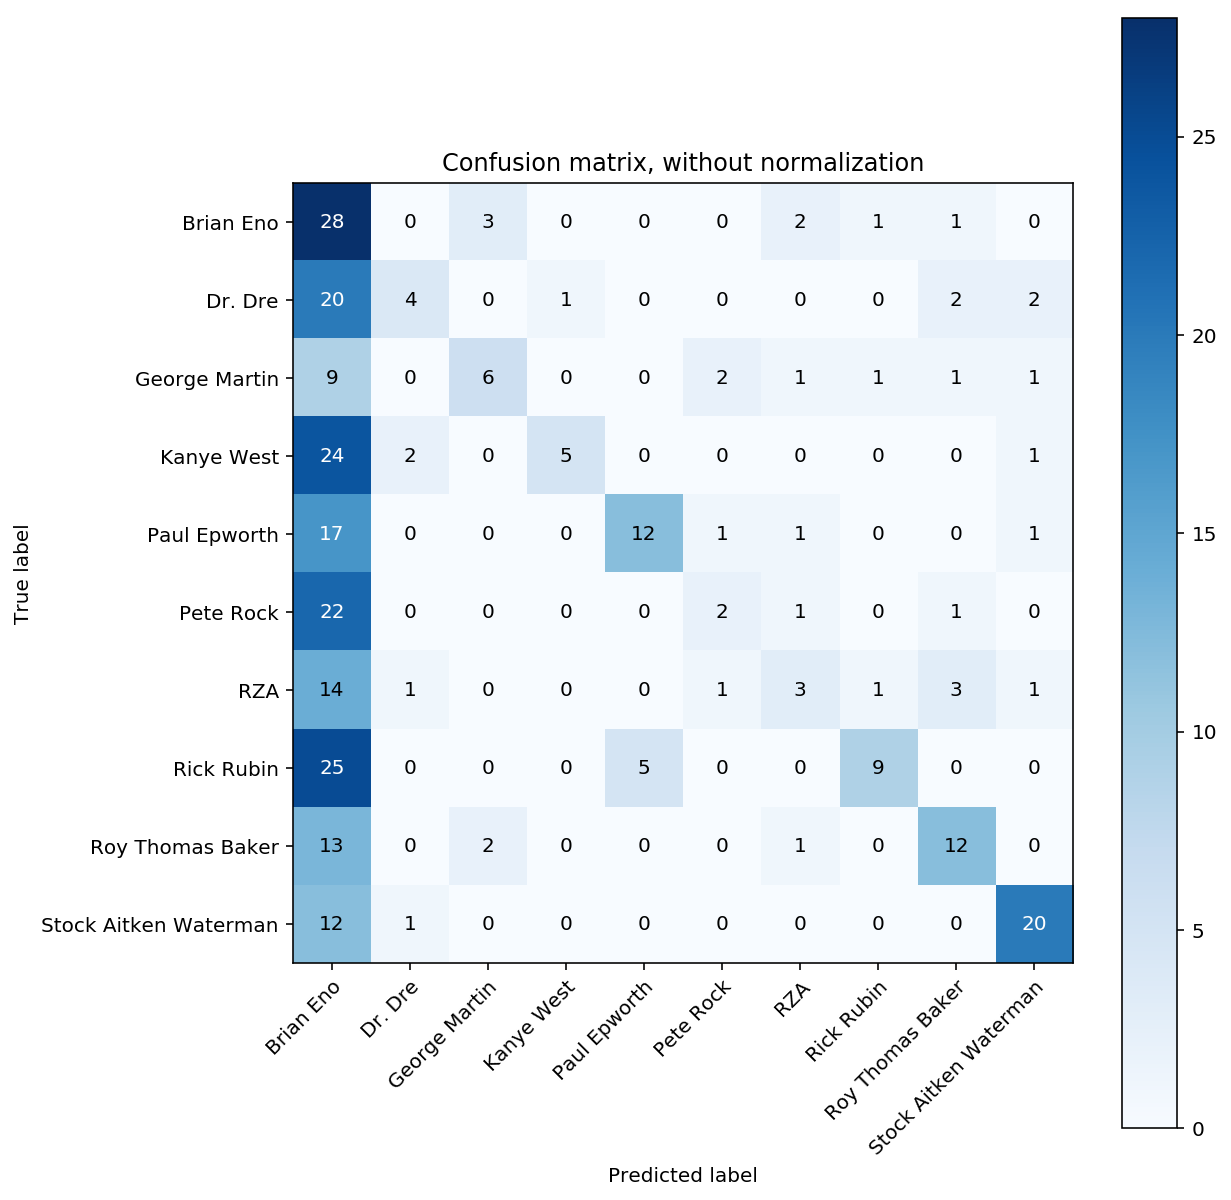

In [60]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,12))
plot_confusion_matrix(y_test_labels, y_hat_labels, classes=y_columns,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_had, classes=y_columns, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [61]:
genre_count.max()/genre_count.sum()

0.37775202780996525

# Hmmm seems suspicious that Country and Brian Eno both get the most votes.

In [68]:
y_hat.sum(axis = 0)

array([ 9,  8, 11,  6, 17,  6,  9, 12, 20, 26], dtype=uint64)

In [63]:
y_test.sum(axis = 0)

array([35, 29, 21, 32, 32, 26, 24, 39, 28, 33], dtype=uint64)

In [72]:
y_hat[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [74]:
pd.get_dummies(pd.DataFrame({'color':['r','g','b','b','g','r']}))

color_b  color_g  color_r
0        0        0        1
1        0        1        0
2        1        0        0
3        1        0        0
4        0        1        0
5        0        0        1

In [87]:
np.unique(y_train, axis = 0)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [85]:
np.unique(y_hat, axis = 0)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [102]:
# knn.predict_proba(X_test_pca[0].reshape(1,-1))
knn.predict(X_test_pca[0].reshape(1,-1))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [101]:
knn.predict_proba(X_test_pca[2].reshape(1,-1))
knn.predict(X_test_pca[2].reshape(1,-1))

[array([[0.8, 0.2]]),
 array([[1., 0.]]),
 array([[0.8, 0.2]]),
 array([[0.8, 0.2]]),
 array([[1., 0.]]),
 array([[1., 0.]]),
 array([[0.6, 0.4]]),
 array([[1., 0.]]),
 array([[1., 0.]]),
 array([[1., 0.]])]

In [115]:
np.argmax(np.stack(knn.predict_proba(X_test_pca[2].reshape(1,-1)))[:,0,1])

6

In [123]:
y_hat_args = np.argmax(np.stack(knn.predict_proba(X_test_pca))[:,:,1].T, axis = 1)

In [124]:
acc = (y_test_labels == y_hat_args).sum()/y_test_labels.size

print("Producer Accuracy = {}".format(acc))

Producer Accuracy = 0.391304347826087


Confusion matrix, without normalization
[[12  2 11  0  1  1  3  3  2  0]
 [ 1 12  2  4  1  0  1  0  4  4]
 [ 5  0  6  1  0  3  2  1  1  2]
 [ 7  8  2 10  2  1  0  0  1  1]
 [ 3  1  3  0 20  1  1  1  0  2]
 [ 3  5  2  3  2  3  3  0  3  2]
 [ 2  4  1  1  0  3  7  1  4  1]
 [ 5  1  0  0 17  2  1 10  1  2]
 [ 3  0  8  0  0  1  1  0 15  0]
 [ 3  4  3  0  1  0  0  0  0 22]]
Normalized confusion matrix
[[0.34 0.06 0.31 0.   0.03 0.03 0.09 0.09 0.06 0.  ]
 [0.03 0.41 0.07 0.14 0.03 0.   0.03 0.   0.14 0.14]
 [0.24 0.   0.29 0.05 0.   0.14 0.1  0.05 0.05 0.1 ]
 [0.22 0.25 0.06 0.31 0.06 0.03 0.   0.   0.03 0.03]
 [0.09 0.03 0.09 0.   0.62 0.03 0.03 0.03 0.   0.06]
 [0.12 0.19 0.08 0.12 0.08 0.12 0.12 0.   0.12 0.08]
 [0.08 0.17 0.04 0.04 0.   0.12 0.29 0.04 0.17 0.04]
 [0.13 0.03 0.   0.   0.44 0.05 0.03 0.26 0.03 0.05]
 [0.11 0.   0.29 0.   0.   0.04 0.04 0.   0.54 0.  ]
 [0.09 0.12 0.09 0.   0.03 0.   0.   0.   0.   0.67]]


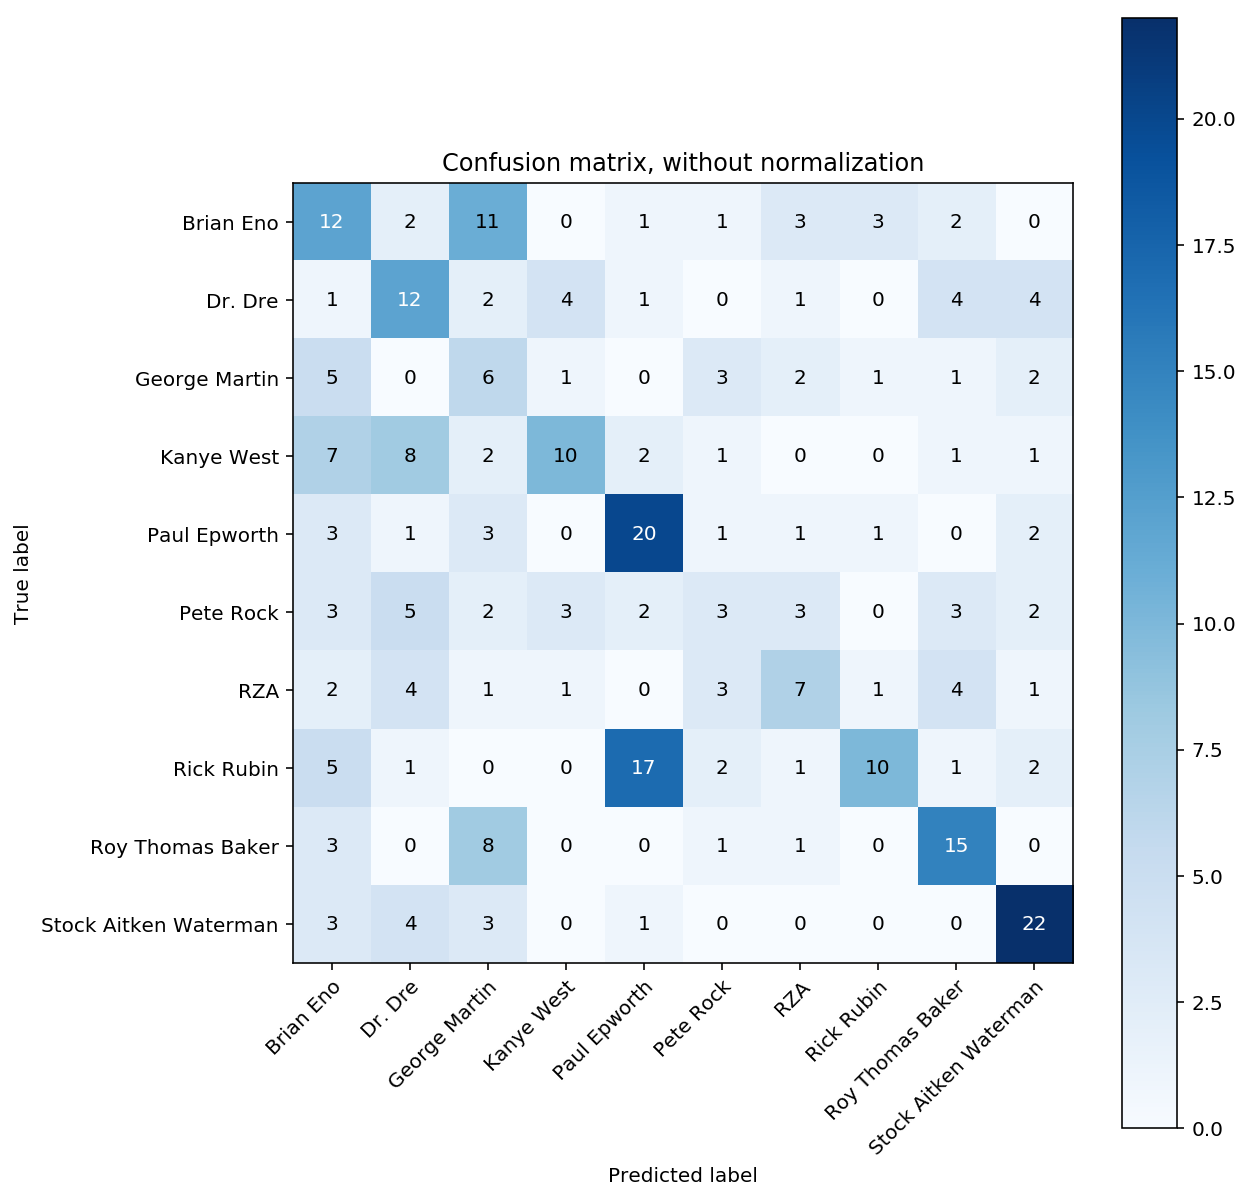

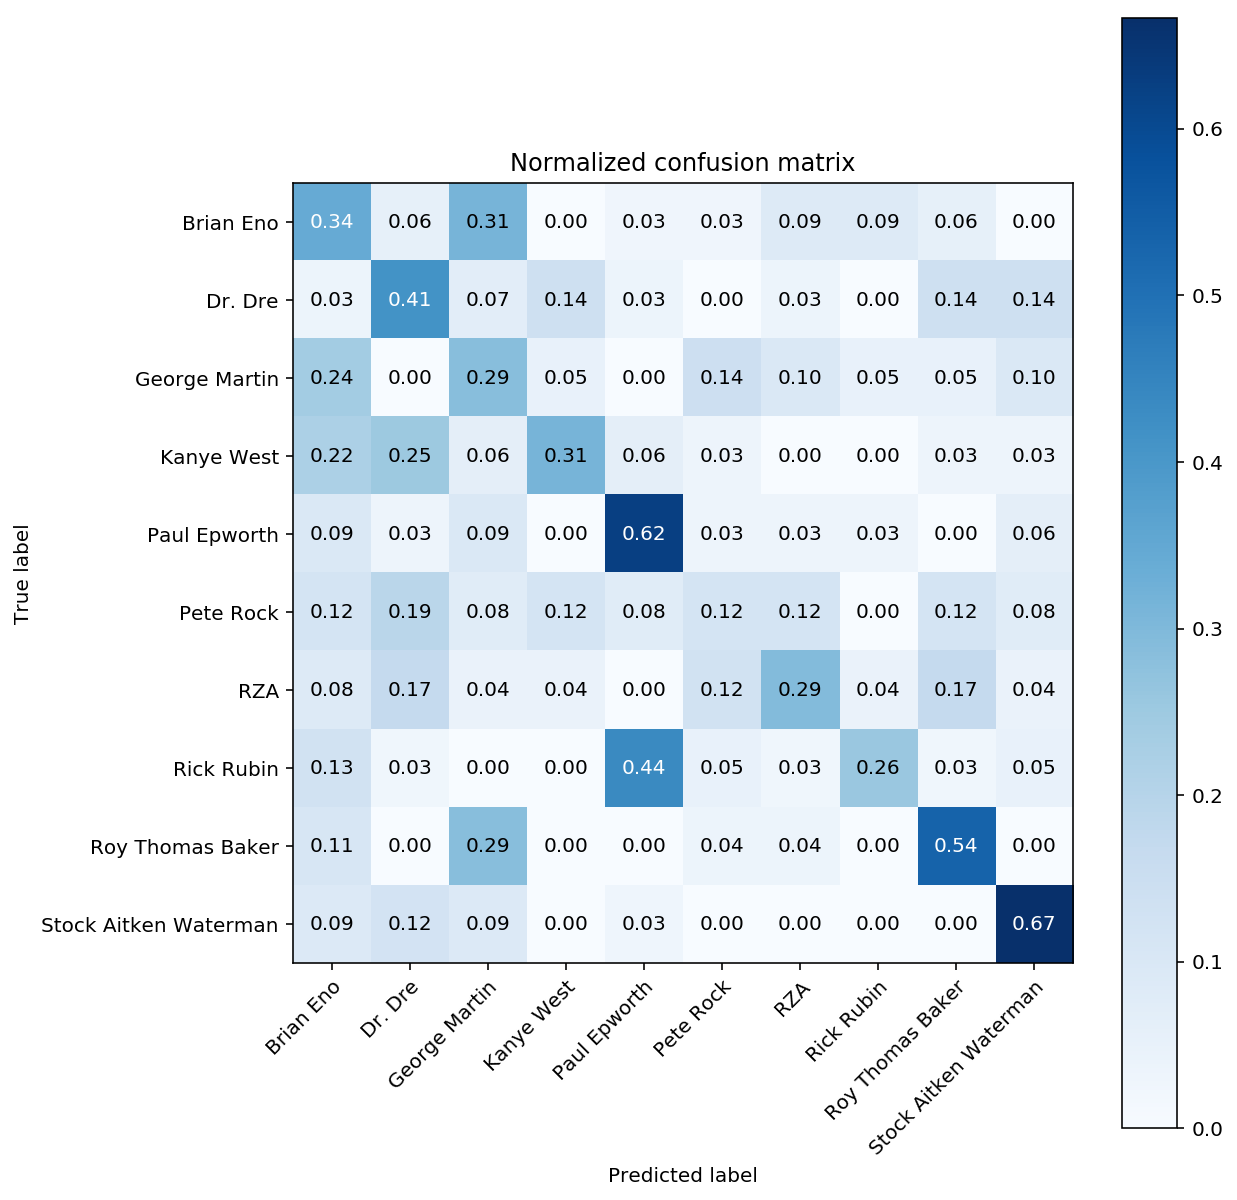

In [128]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_labels, y_hat_args, classes=y_columns,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
plot_confusion_matrix(y_test_labels, y_hat_args, classes=y_columns, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Using t-SNE to plot multidimensional data

Take MFCC data and use PCA to transform to a lower-dimensional space D = 50

In [178]:
X = []
y = []

for song in mfcc_collection.find():
    if np.array(song['MFCC']).shape[1] >= 1292:
        X.append(np.array(song['MFCC'])[:,:1292].flatten())
        y.append(song['producer'])


#NEED TO STACK LIST OF MFCCS 
X = np.vstack(X)
y = np.array(y)

y_one_hot = pd.get_dummies(y).values
y_columns = np.array(pd.get_dummies(y).columns)

X_train, X_test, y_train, y_test = train_test_split(X ,y_one_hot, test_size = 0.3, random_state = 440)

# Standardize
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA(n_components=100)

X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

In [149]:
from sklearn.manifold import TSNE

In [162]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1((y[i]+1) / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [201]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time.time()
X_tsne2 = tsne.fit_transform(X_train_pca, np.argmax(y_train, axis=1))

# plot_embedding(X_tsne,
#                "t-SNE embedding of the digits (time %.2fs)" %
#                (time.time() - t0))

# plt.show()

In [202]:
X_tsne

array([[  4.08,  -8.8 ,   6.78],
       [-45.97, -66.86,  48.78],
       [ 57.64,  45.09,  65.06],
       ...,
       [ 43.5 ,  52.42,  54.99],
       [ 76.95, -41.44, -69.17],
       [ -4.08,  70.95,  24.8 ]], dtype=float32)

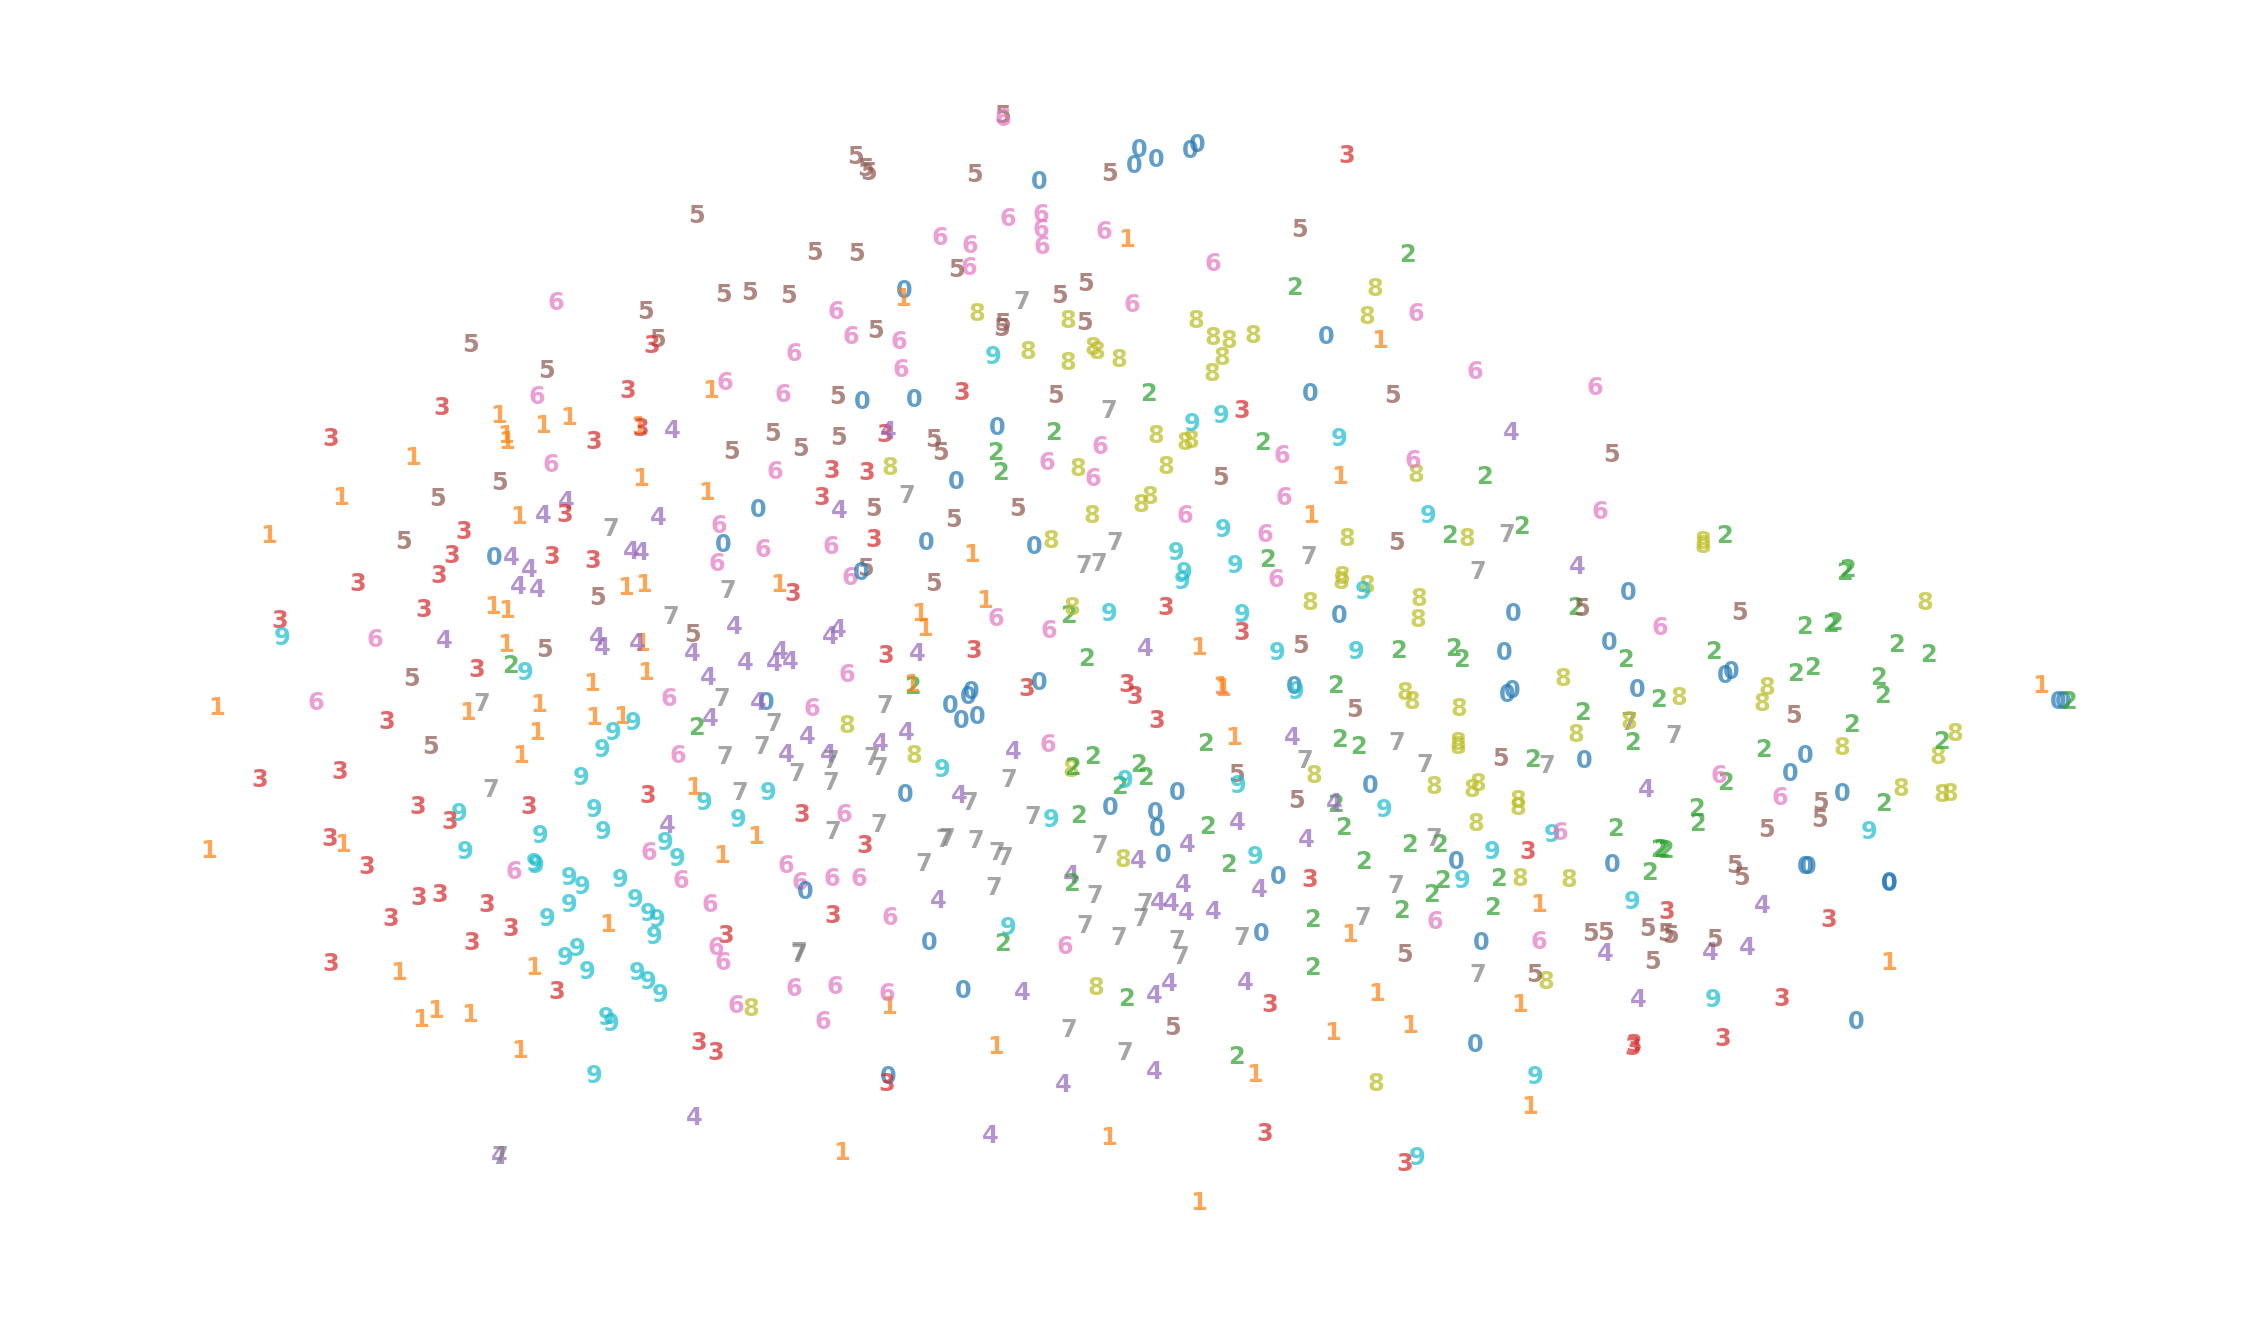

In [203]:
fig, ax = plt.subplots(figsize=(20, 12))
plot_mnist_embedding(ax, X_tsne2, np.argmax(y_train, axis = 1), alpha = 0.7)

In [204]:
for i, producer in enumerate(y_columns):
    print (i, producer)

0 Brian Eno
1 Dr. Dre
2 George Martin
3 Kanye West
4 Paul Epworth
5 Pete Rock
6 RZA
7 Rick Rubin
8 Roy Thomas Baker
9 Stock Aitken Waterman


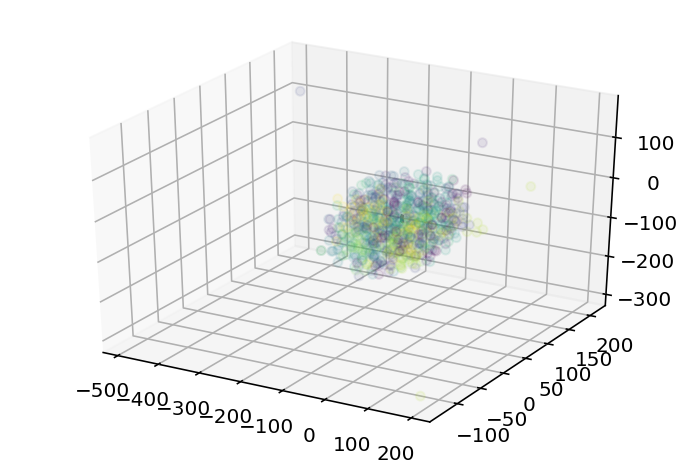

In [188]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xs = X_tsne[:,0], ys = X_tsne[:,1], zs = X_tsne[:,2], c = np.argmax(y_train, axis = 1), alpha = 0.1);

In [173]:
for i, producer in enumerate(y_columns):
    print (i, producer)

0 Brian Eno
1 Dr. Dre
2 George Martin
3 Kanye West
4 Paul Epworth
5 Pete Rock
6 RZA
7 Rick Rubin
8 Roy Thomas Baker
9 Stock Aitken Waterman


In [192]:
import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np

x, y, z = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
trace2 = go.Scatter3d(
    x=x2,
    y=y2,
    z=z2,
    mode='markers',
    marker=dict(
        color='rgb(127, 127, 127)',
        size=12,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.9
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~maxwellfisch/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


/Users/Maxwell/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [198]:
x, y, z = X_tsne[:,0], X_tsne[:,1], X_tsne[:,2]
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color=np.argmax(y_train, axis = 1),
            colorscale = 'Viridis'
#             width=0.5
        ),
        opacity=0.8
    )
)

# x2, y2, z2 = np.random.multivariate_normal(np.array([0,0,0]), np.eye(3), 200).transpose()
# trace2 = go.Scatter3d(
#     x=x2,
#     y=y2,
#     z=z2,
#     mode='markers',
#     marker=dict(
#         color='rgb(127, 127, 127)',
#         size=12,
#         symbol='circle',
#         line=dict(
#             color='rgb(204, 204, 204)',
#             width=1
#         ),
#         opacity=0.9
#     )
# )
data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~maxwellfisch/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


/Users/Maxwell/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [193]:
x, y, z = X_tsne[:,0], X_tsne[:,1], X_tsne[:,2]

ValueError: too many values to unpack (expected 3)

In [205]:
x, y, z = X_tsne[:,0], X_tsne[:,1], X_tsne[:,2]

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=np.argmax(y_train, axis = 1),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

/Users/Maxwell/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

